<a href="https://colab.research.google.com/github/jm12312/Data-Science-And-ML/blob/main/Animal_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/alessiocorrado99/animals10/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: joshuamenezes
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10


100%|██████████| 586M/586M [00:02<00:00, 232MB/s]


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms as tt
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
import numpy as np

In [ ]:
# transform = tt.Compose([
#     tt.Resize((224, 224)),
#     tt.ToTensor()
# ]
# )

# # Load your dataset without normalization
# all_data = datasets.ImageFolder("/content/animals10/raw-img", transform=transform)

# # Calculate the mean and standard deviation for the dataset
# def calculate_mean_std(dataset):
#     # Create a DataLoader to iterate through the dataset
#     data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)

#     # Initialize variables to store sum of pixels and sum of squared pixels
#     mean = 0.0
#     std = 0.0
#     total_images = 0

#     # Iterate through the dataset and accumulate pixel values
#     for images, _ in data_loader:
#         # Calculate the mean and std for each batch of images
#         batch_samples = images.size(0)  # Number of images in the batch
#         images = images.view(batch_samples, images.size(1), -1)  # Reshape to (batch_size, channels, width*height)

#         mean += images.mean(dim=2).sum(dim=0)  # Sum the mean for each channel
#         std += images.std(dim=2).sum(dim=0)    # Sum the std for each channel
#         total_images += batch_samples

#     # Calculate the final mean and std by dividing by the total number of images
#     mean /= total_images
#     std /= total_images

#     return mean, std

# # Call the function to compute mean and std
# mean, std = calculate_mean_std(all_data)

# # Print the mean and std for each channel (RGB)
# print("Mean:", mean)
# print("Std:", std)

In [3]:
train_transform = tt.Compose([
    tt.Resize((224, 224)),  # Resize images to 224x224
    tt.RandomCrop(224, padding=4, padding_mode="reflect"),
    tt.RandomHorizontalFlip(p=0.5),
    tt.RandomRotation(10) ,
    tt.ToTensor(),
    tt.Normalize((0.5177, 0.5003, 0.4126), (0.2133, 0.2130, 0.2149), inplace=True),
    tt.RandomErasing(p=0.5),
])
valid_transform = tt.Compose([
    tt.Resize((224, 224)),
    tt.ToTensor(),
    tt.Normalize((0.5177, 0.5003, 0.4126), (0.2133, 0.2130, 0.2149))
])

In [4]:
all_data = ImageFolder(root="/content/animals10/raw-img")

**Augmentations left**


In [5]:
len(all_data)

26179

In [6]:
generator1 = torch.Generator().manual_seed(42)

In [7]:
train_dataset, val_dataset, test_dataset = random_split(all_data, [18000, 4000, 4179], generator=generator1)

In [8]:
train_dataset = ImageFolder(root="/content/animals10/raw-img", transform=train_transform)
val_dataset = ImageFolder(root="/content/animals10/raw-img", transform=valid_transform)
test_dataset = ImageFolder(root="/content/animals10/raw-img", transform=valid_transform)

In [9]:
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=128)
test_dl = DataLoader(test_dataset, batch_size=128)

In [10]:
for img, label in train_dl:
  print(img.shape)
  break

torch.Size([128, 3, 224, 224])


In [11]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

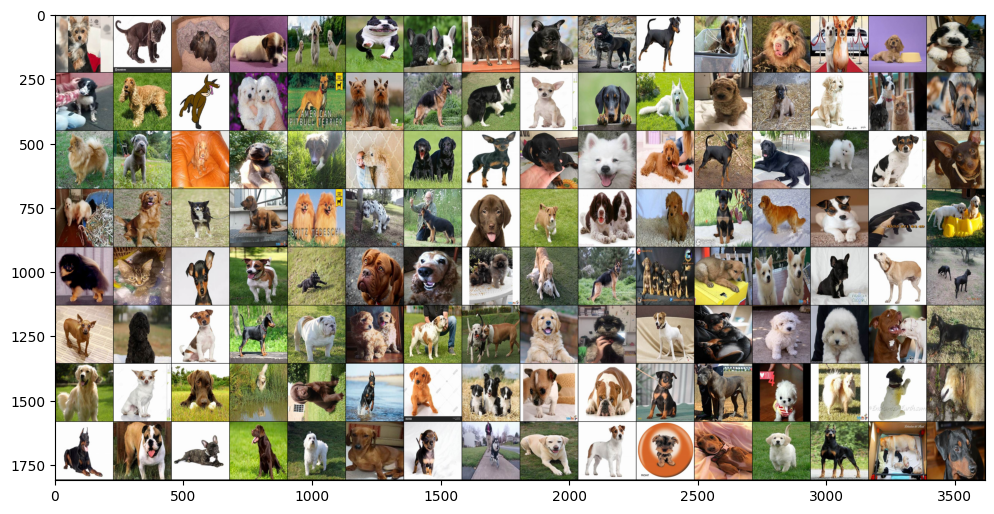

In [12]:
for img, label in val_dl:
  plt.figure(figsize=(12, 12))
  denorm_img = denormalize(img, (0.5177, 0.5003, 0.4126), (0.2133, 0.2130, 0.2149))
  plt.imshow(make_grid(denorm_img.cpu(), nrow=16).permute(1, 2, 0))
  break

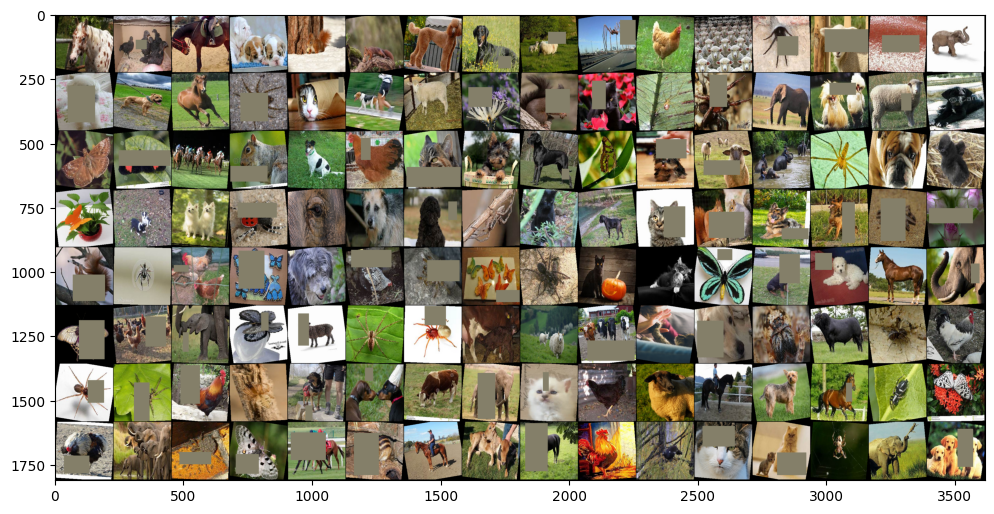

In [13]:
for img, label in train_dl:
  plt.figure(figsize=(12, 12))
  denorm_img = denormalize(img, (0.5177, 0.5003, 0.4126), (0.2133, 0.2130, 0.2149))
  plt.imshow(make_grid(denorm_img.cpu(), nrow=16).permute(1, 2, 0))
  break

In [14]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [36]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f'Epoch: {epoch}, Train Loss: {result["train_loss"]} ,Val Loss: {result["val_loss"]}, Val Acc: {result["val_acc"]}')

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [17]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class CNN(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.conv1 = conv_block(3, 64, pool=True)  # 64, 112, 112
    self.conv2 = conv_block(64, 128, pool=True) # 128, 56, 56
    self.conv3 = conv_block(128, 256, pool=True) # 256, 28, 28
    self.conv4 = conv_block(256, 256, pool=True) # 256, 14, 14
    self.conv5 = conv_block(256, 256, pool=True) # 256, 7, 7
    self.classifier = nn.Sequential(
        nn.MaxPool2d(7),
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(256, 10)
    )

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.conv5(out)
    return self.classifier(out)

In [26]:
model = to_device(CNN(), device)
model

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(model, opt, train_dl, loss_fn, epochs, val_loader):
  torch.cuda.empty_cache()
  history = []
  train_loss = []
  model.train()
  for epoch in range(epochs):
    for img, label in train_dl:
      loss = model.training_step((img, label))
      train_loss.append(loss)
      loss.backward()
      opt.step()
      opt.zero_grad()

    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_loss).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 2.3099284172058105, 'val_acc': 0.0732850581407547}]

In [ ]:
history += fit(model, torch.optim.Adam(model.parameters(), lr=1e-2), train_dl, F.cross_entropy, 5, val_dl)

Epoch: 0, Train Loss: 2.2893199920654297 ,Val Loss: 1.9892399311065674, Val Acc: 0.30024969577789307
Epoch: 1, Train Loss: 2.0078535079956055 ,Val Loss: 1.4969631433486938, Val Acc: 0.4980848431587219
Epoch: 2, Train Loss: 1.8006365299224854 ,Val Loss: 1.2233338356018066, Val Acc: 0.5808285474777222
Epoch: 3, Train Loss: 1.6503212451934814 ,Val Loss: 1.0217400789260864, Val Acc: 0.6429412364959717
Epoch: 4, Train Loss: 1.5352689027786255 ,Val Loss: 0.965080976486206, Val Acc: 0.6673114895820618


In [ ]:
history += fit(model, torch.optim.Adam(model.parameters(), lr=1e-3), train_dl, F.cross_entropy, 3, val_dl)

Epoch: 0, Train Loss: 1.3727277517318726 ,Val Loss: 0.9150007963180542, Val Acc: 0.6897706389427185
Epoch: 1, Train Loss: 1.1383841037750244 ,Val Loss: 0.7524001598358154, Val Acc: 0.7481974363327026
Epoch: 2, Train Loss: 1.0337194204330444 ,Val Loss: 0.7080951929092407, Val Acc: 0.7628589272499084


In [ ]:
history += fit(model, torch.optim.Adam(model.parameters(), lr=5e-4), train_dl, F.cross_entropy, 3, val_dl)

Epoch: 0, Train Loss: 1.093607783317566 ,Val Loss: 0.7656620144844055, Val Acc: 0.7524065971374512
Epoch: 1, Train Loss: 0.9447243809700012 ,Val Loss: 0.6910855174064636, Val Acc: 0.7657347917556763
Epoch: 2, Train Loss: 0.8803512454032898 ,Val Loss: 0.6562834978103638, Val Acc: 0.7772541046142578


In [28]:
history += fit(model, torch.optim.Adam(model.parameters(), lr=1e-4), train_dl, F.cross_entropy, 5, val_dl)

Epoch: 0, Train Loss: 1.0303783416748047 ,Val Loss: 0.7147204279899597, Val Acc: 0.7674252390861511
Epoch: 1, Train Loss: 0.8931453227996826 ,Val Loss: 0.6663814783096313, Val Acc: 0.7818586230278015
Epoch: 2, Train Loss: 0.8401865363121033 ,Val Loss: 0.6507235169410706, Val Acc: 0.7850979566574097
Epoch: 3, Train Loss: 0.8114374876022339 ,Val Loss: 0.6408751010894775, Val Acc: 0.7863174676895142
Epoch: 4, Train Loss: 0.792076826095581 ,Val Loss: 0.637413501739502, Val Acc: 0.7870449423789978


In [96]:
history += fit(model, torch.optim.Adam(model.parameters(), lr=1e-4), train_dl, F.cross_entropy, 3, val_dl)

Epoch: 0, Train Loss: 1.002476692199707 ,Val Loss: 0.6884616613388062, Val Acc: 0.7739004492759705
Epoch: 1, Train Loss: 0.8691705465316772 ,Val Loss: 0.6471428275108337, Val Acc: 0.7865080237388611
Epoch: 2, Train Loss: 0.8187397718429565 ,Val Loss: 0.6399542093276978, Val Acc: 0.7850666046142578


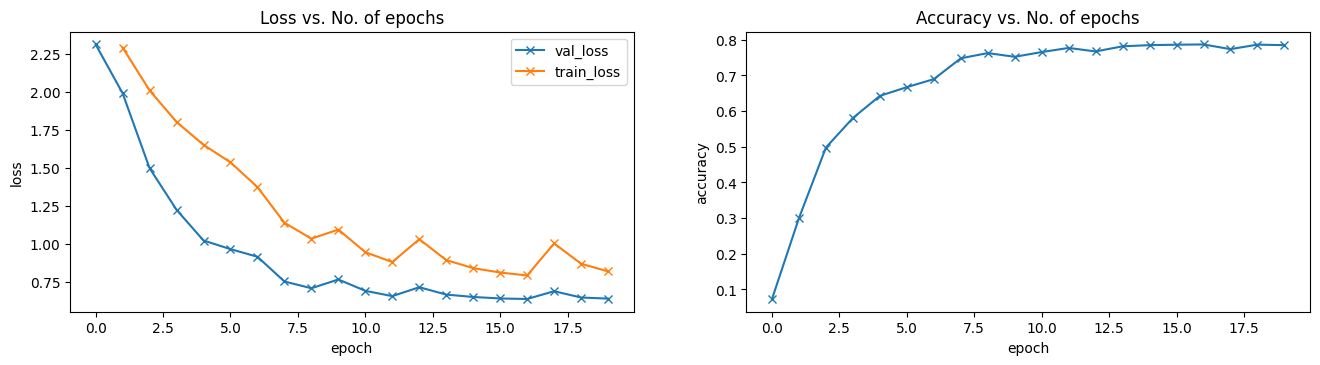

In [97]:
def plot_metrics(history):
    plt.figure(figsize=(16, 8))

    plt.subplot(2, 2, 1)
    val_loss = [x['val_loss'] for x in history]
    train_loss = [x.get('train_loss', None) for x in history]

    plt.plot(val_loss, '-x')
    plt.plot(train_loss, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')
    plt.legend(['val_loss', 'train_loss'])


    plt.subplot(2, 2, 2)
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_metrics(history)

**Custom Inputs**

In [37]:
evaluate(model, test_dl)

{'val_loss': 0.637413501739502, 'val_acc': 0.7870449423789978}

In [44]:
translate = {0: "dog", 1: "horse", 2: "elephant", 3: "butterfly", 4: "chicken", 5: "cat", 6: "cow", 7: "sheep", 8: "squirrel", 9: "spider"}

In [40]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    op = model(xb)
    _, pred = torch.max(op, dim=1)
    return pred[0].item()

Label: 0 , Predicted: 0


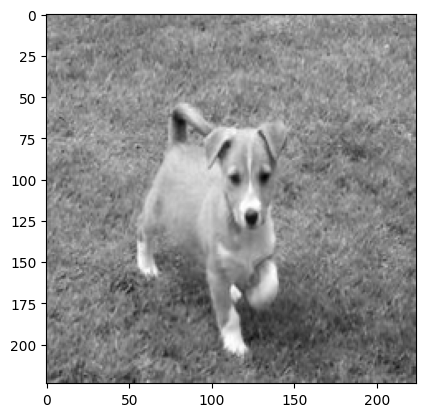

In [95]:
img, label = val_dataset[56]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
import joblib
torch.save(model.state_dict(), 'model_animal10_classification_cnn_model1.pth')
joblib.dump(history, "history_of_animal10_classification.pkl")

['history_of_animal10_classification.pkl']

In [27]:
import joblib
history = joblib.load("history_of_animal10_classification.pkl")
model.load_state_dict(torch.load("/content/model_animal10_classification_cnn_model1.pth"))

<ipython-input-27-19283d6f315b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/model_animal10_classification_cnn_model1.pth"))


<All keys matched successfully>

In [ ]:
model.load_state_dict(torch.load('model_animal10_classification_cnn.pth'))

<ipython-input-18-ab53827f161c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_animal10_classification_cnn.pth'))


<All keys matched successfully>